# Difference-in-difference in a repeated cross-sample

## Background

Assume we are measuring observations for a repeated cross-sample of units (e.g., customers at a marketing platform, new bank loans etc.) at time points $t = 0, 1, \cdots 5$. There are two distinguished groups of units, for example, from two different areas, with 300 ($i=0, \dots , 299$) observations in each group in each time. Imagine that in one of the areas there is an one-off intervention (e.g., a government stimulus package) taking place between between time points 2 and 3 that might affect a key characteristic of the units (e.g., time spent on the site, pricing of the loans). We are interested in the **treatment effect** of the intervention on this characteristic.

## Data generating process

Let $Y_{i,t}^j$ denote the characteristic of interest for unit $i$ from area $j$ at time $t$. Let the intervention take place in group $i=T$ (treatment group) and let there be no intervention in group $i=C$ (control group). We assume the true **data generating process (DGP)** of $Y_{i,t}^j$ follows

$$
\begin{equation*}
  Y_{i,t}^j = TR_{i,t}^j + GC^{j} + TGC_{t}^{j} + \tau_{i,t} D_{i,t}^j + e_{i, t} \\
\end{equation*}
$$

where 

 - $TR_{i,t}^j = b^j * t * N(0, 1)$ is a noisy linear time trend with group-specific weight $b^j$;
 - $GC^{j} \sim N(\mu_{GC}^j, \sigma_{GC}^j)$ denotes time-invariant effect(s);
 - $e_{i, t}^j \sim N(0, 1)$ denotes unit-specific idiosyncrasies;
 - $D_{i,t}^j$ denotes the intervention dummy: $D_{i,t}^C = 0$ for all $t$, $D_{i,t}^T = 1$ for $t \geq 2$ but 0 othwerwise. $\tau_{i,t}$ is the treatment effect size for unit $i$ at time $t$;  
 - $TGC_{t}^{j}$ denotes time and group variant effect(s):

$$
\begin{equation*}
  TGC_t=\begin{cases}
    N(\mu_{TGC}^C, \sigma_{TGC}^C) & \quad | \  t > 2 \text{ and } j=C \\[4pt]
    N(0, \sigma_{TGC}^C) & \quad | \  t \leq 2 \text{ and } j=C \\[4pt]
    N(\mu_{TGC}^T, \sigma_{TGC}^T) & \quad | \  j=T
  \end{cases}
\end{equation*}
$$

$TGC_{t}^{j}$ and $TR_{i,t}^j$ are similar in the sense that both are group-specific. However, the idea is that the effect via $TGC_{t}^{j}$ can be heterogenous over time wihtin the group, while $TR_{i,t}^j$ will just be a linear trend over time for group $j$. In the examples we will typically resort to using a common trend (by setting $b^C = b^T$).

Notice that **in reality the true data generating process is unknown to the researcher**! Here we use simulated data (properties of which we know) to help us understand the properties of our research design and regression models. As advocated by [Gelman, Hill and Vehtari (2020, section 5.5)](https://avehtari.github.io/ROS-Examples/), fake-data simulation is a "way of life" to evaluate the statistical methods being used.

## Research design

Assume we are interested in the average **treatment effect on the treated** (ATT), that is, average of $\tau_{i,t}$ over treated units$. That is, we would like to know how much did the intervetion affect (on average) the character of interest of observation in the treated group (at given time). We can write this **estimand** in a mathematical form using potential outcome notation:

$$
\begin{equation*}
    \theta_t = E[Y_{i,t}^T(1)] - E[Y_{i,t}^T(0)]
\end{equation*}
$$

where 

 - $Y_{i,t}^T(1)$ denotes an observation in treated group had it faced an intervention;
 - $Y_{i,t}^T(0)$ denotes an observation in treated group had it not faced an intervention;
 - expectation operator is to be undertood to average over units $i$.
 
Since we have a well-defined, one-off intervention and well-defined tretment/control groups, we can use a  classical **difference-in-difference (DiD)** research design. See my [flashcard](https://raw.githubusercontent.com/NoobQuant/Data_Science_Projects/master/flashcards/diff_in_diff.jpg) for more on DiD.

By the way, make sure you understand the difference between a **research design** and the **statistical model**. Sometimes people refer to DiD when talking about the research design (design to tease out causal effect of interest) or the statistical model (statistical regression model).

## Imports

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import warnings
warnings.filterwarnings('ignore')
np.random.seed(1)
import rpy2
%load_ext rpy2.ipython

D:\Anaconda3\envs\dev2021b\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
%%R
library(dagitty)

## Helper functions

In [3]:
def simulate_data(
    tau,
    b_c,
    b_t,
    mu_gc_c,
    sigma_gc_c,
    mu_gc_t,
    sigma_gc_t,
    mu_tgc_c,
    sigma_tgc_c,
    mu_tgc_t,
    sigma_tgc_t,
    **kwargs,
):
    
    # Optional parameters
    no_periods = kwargs.get("no_periods", 6)
    last_pre_timepoint = kwargs.get("last_pre_timepoint", 2) 
    no_obs = kwargs.get("no_obs", 300)     
    
    for t in range(no_periods):

        common_random_trend_deviation = np.abs(np.random.random())

        # Control group
        df_t = pd.DataFrame(np.random.random(size=no_obs), columns=["Y"]) + b_c * t * common_random_trend_deviation

        # Group confounding for control
        df_t["GC"] = np.random.normal(loc=mu_gc_c, scale=sigma_gc_c, size=no_obs)
        df_t["Y"] = df_t["Y"] + df_t["GC"]

        # Time confounding for control
        if t >= last_pre_timepoint:
            df_t["TGC"] = np.random.normal(loc=mu_tgc_c, scale=sigma_tgc_c, size=no_obs)
            df_t["Y"] = df_t["Y"] + df_t["TGC"]
        else:
            df_t["TGC"] = np.random.normal(loc=0, scale=sigma_tgc_c, size=no_obs)
            df_t["Y"] = df_t["Y"] + df_t["TGC"]

        df_t["t"] = t
        if t == 0:
            control = df_t
        else:
            control = control.append(df_t, ignore_index=True)

        # Treatment group
        df_t = pd.DataFrame(np.random.random(size=no_obs), columns=["Y"]) + b_t * t * common_random_trend_deviation

        # Group confounding for treatment
        df_t["GC"] = np.random.normal(loc=mu_gc_t, scale=sigma_gc_t, size=no_obs)
        df_t["Y"] = df_t["Y"] + df_t["GC"]

        # Time confounding for treatment
        df_t["TGC"] = np.random.normal(loc=mu_tgc_t, scale=sigma_tgc_t, size=no_obs)
        df_t["Y"] = df_t["Y"] + df_t["TGC"]

        df_t["t"] = t
        if t == 0:
            treatment_cf = df_t
        else:
            treatment_cf = treatment_cf.append(df_t, ignore_index=True)

    treatment_cf["time_group"] = np.where(treatment_cf["t"] > last_pre_timepoint, "after", "before")
    control["time_group"] = np.where(control["t"] > last_pre_timepoint, "after", "before")
    treatment_cf["tc_group"] = "treatment"
    control["tc_group"] = "control"

    treatment = treatment_cf.copy()
    treatment.loc[treatment["time_group"] == "after", "Y"] = treatment.loc[treatment["time_group"] == "after", "Y"] + tau

    # Save mean values
    means = {}
    means["control_before"] = control.query("time_group == 'before'")["Y"].mean()
    means["control_after"] = control.query("time_group == 'after'")["Y"].mean()
    means["treatment_before"] = treatment.query("time_group == 'before'")["Y"].mean()
    means["treatment_after"] = treatment.query("time_group == 'after'")["Y"].mean()
    means["treatment_cf_before"] = treatment_cf.query("time_group == 'before'")["Y"].mean()
    means["treatment_cf_after"] = treatment_cf.query("time_group == 'after'")["Y"].mean()
    for t in range(no_periods):
        means["control_t" + str(t)] = control.query("t == {}".format(t))["Y"].mean()
        means["treatment_t" + str(t)] = treatment.query("t == {}".format(t))["Y"].mean()
        means["treatment_cf_t" + str(t)] = treatment_cf.query("t == {}".format(t))["Y"].mean()
        
    return {"treatment": treatment, "control": control, "treatment_cf": treatment_cf, "means": means}

# https://www.learnui.design/tools/data-color-picker.html
colors = [
    "#003f5c",
    "#2f4b7c",
    "#665191",
    "#a05195",
    "#d45087",
    "#f95d6a",
    "#ff7c43",
    "#ffa600",
]

def plot_data(data, **kwargs):
    
    no_periods = kwargs.get("no_periods", 6)
    last_pre_timepoint = kwargs.get("last_pre_timepoint", 2)
    
    treatment = data["treatment"]
    control = data["control"]
    treatment_cf = data["treatment_cf"]
    means = data["means"]
    
    time_fe_mean_line_pos = [(0, 0.1), (0.175, 0.275), (0.375, 0.475), (0.55, 0.65), (0.75, 0.825), (0.90, 1)]
    def format_ax(ax):
        ax.set_ylabel("Y")
        ax.axvline(2.5, linestyle="-", c=colors[0], linewidth=2)
        #ax.set_ylim(-4, 10)
        ax.legend()
        
    fig = plt.figure(figsize=(14, 10))

    ax = fig.add_subplot(2, 1, 1)
    control.plot.scatter(x="t", y="Y", ax=ax, s=1, c=colors[3], label="Realized observations")
    ax.axhline(y=means["control_before"], xmin=0, xmax=0.5, linestyle="--", c=colors[3], label="Realized pre/post-period means and individual time-point means")
    ax.axhline(y=means["control_after"], xmin=0.5, xmax=1.0, linestyle="--", c=colors[3])
    for t, xminmax in zip(range(no_periods), time_fe_mean_line_pos):
        ax.axhline(y=means["control_t" + str(t)], xmin=xminmax[0], xmax=xminmax[1], linestyle="--", c=colors[3])
    format_ax(ax)
    ax.set_title("Control group")
    ax.set_xlabel(None)

    ax = fig.add_subplot(2, 1, 2)
    # Realized
    treatment.plot.scatter(x="t", y="Y", ax=ax, s=1, c=colors[3], label="Realized observations")
    ax.axhline(y=means["treatment_before"], xmin=0, xmax=0.5, linestyle="--", c=colors[3], label="Realized pre/post-period means and individual time-point means")
    ax.axhline(y=means["treatment_after"], xmin=0.5, xmax=1.0, linestyle="--", c=colors[3])
    for t, xminmax in zip(range(no_periods), time_fe_mean_line_pos):
        ax.axhline(y=means["treatment_t" + str(t)], xmin=xminmax[0], xmax=xminmax[1], linestyle="--", c=colors[3])
    # Counterfactual (unobserved)
    treatment_cf.query("time_group == 'after'").plot.scatter(x="t", y="Y", ax=ax, color=colors[6], s=1, label="Counterfactual observations (unobserved)")
    ax.axhline(y=means["treatment_cf_after"], xmin=0.5, xmax=1.0, linestyle="--", c=colors[6], label="Counterfactual post-period mean (unobserved)")
    for t, xminmax in zip(range(last_pre_timepoint+1, no_periods), time_fe_mean_line_pos[last_pre_timepoint+1:]):
           ax.axhline(y=means["treatment_cf_t" + str(t)], xmin=xminmax[0], xmax=xminmax[1], linestyle="--", color=colors[6])

    # Counterfactual (estimated)
    ax.axhline(y=means["treatment_before"] + (means["control_after"] - means["control_before"]), xmin=0.5, xmax=1.0,
        linestyle="--", color=colors[4], label="Counterfactual post-period mean (naively estimated)")

    format_ax(ax)
    ax.set_title("Treatment group")
    fig.tight_layout()
    
    # Prints
    print("Realized control pre-period mean {:.3f}".format(means["control_before"]))
    print("Realized control post-period mean {:.3f}".format(means["control_after"]))
    print("Realized treated pre-period mean {:.3f}".format(means["treatment_before"]))
    print("Realized treated post-period mean {:.3f}".format(means["treatment_after"]))
    print("Counterfactual (unobserved) treatment post-period mean {:.3f}".format(means["treatment_cf_after"]))
    for el1, el2 in zip(["control", "treatment", "treatment_cf"],
        ["Realized control", "Realized treated", "Counterfactual treated (unobserved)"]):
        for t in range(no_periods):
            print("{} t_{} mean {:.3f}".format(
                el2,
                t, 
                means[el1 + "_t" + str(t)],
            ))
    print("Counterfactual (naively estimated) treated post-period mean {:.3f}".format(
        means["treatment_before"] + (means["control_after"] - means["control_before"])))
    print("Naive DiD-estimate {:.3f}".format(
        (means["treatment_after"] - means["treatment_before"]) -     
        (means["control_after"] - means["control_before"])
    ))

def parallel_trends_plot(data):
    treatment = data["treatment"].copy()
    control = data["control"].copy()

    fig = plt.figure(figsize=(12, 8))

    ax = fig.add_subplot(2, 1, 1)
    treatment.groupby(["t"]).agg({"Y": "mean"}) \
        .rename(columns={"Y": "Treatment group"}) \
        .plot(ax=ax, linestyle="--", marker="o", c=colors[3])
    control.groupby(["t"]).agg({"Y": "mean"}) \
        .rename(columns={"Y": "Control group"}) \
        .plot(ax=ax, linestyle="--", marker="o", c=colors[5])
    ax.axvline(2.5, c=colors[0])
    ax.set_title("Average Y")

    ax = fig.add_subplot(2, 1, 2)
    treatment.groupby(["t"]).agg({"Y": "mean"}) \
        .subtract(treatment.query("time_group == 'before'").loc[:, "Y"].mean()) \
        .rename(columns={"Y": "Treatment group"}) \
        .plot(ax=ax, linestyle="--", marker="o", c=colors[3])
    control.groupby(["t"]).agg({"Y": "mean"}) \
        .subtract(control.query("time_group == 'before'").loc[:, "Y"].mean()) \
        .rename(columns={"Y": "Control group"}) \
        .plot(ax=ax, linestyle="--", marker="o", c=colors[5])
    ax.axvline(2.5, c=colors[0])
    ax.set_title("De-meaned (using group's pre-period average) average Y")
    
    fig.tight_layout()    

def prepare_regression_frame(treatment, control):
    
    df = treatment.copy().append(control.copy(), ignore_index=True)
    df["dummy_period"] = df["time_group"].copy().map({"before": 0, "after": 1})
    df["dummy_group"] = df["tc_group"].copy().map({"control": 0, "treatment": 1})
    df["dummy_group_x_period"] = df["dummy_period"] * df["dummy_group"]
    df["t"] = df["t"].astype(str)
    
    return df

## DAG of general data generating process

Notice in the DAG $TR_t^j = TR_t$ since the trend is, on average, the same for both groups.

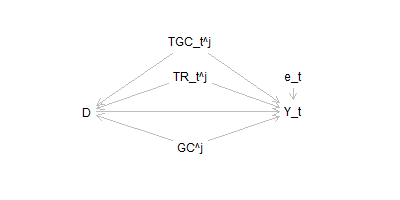

In [4]:
%%R -h 200 -w 400
g = dagitty('
    dag {
    " " [pos="-1.3, -0.4"]
    "" [pos="0.4, 1"]
    "GC^j" [adjusted,pos="-0.5, 0.7"]
    "TGC_t^j" [adjusted,pos="-0.5, -0.2"]
    "TR_t^j" [adjusted,pos="-0.5, 0.1"]
    D [exposure,pos="-1, 0.40"]
    Y_t [outcome,pos="0, 0.40"]
    e_t [pos="0, 0.1"]
    D <- "GC^j" -> Y_t
    D <- "TGC_t^j" -> Y_t
    D <- "TR_t^j" -> Y_t
    D -> Y_t
    e_t -> Y_t
    }
')
plot(g)

## Classical two-period DiD

We start with a specification where in the true data generating process there is, on average, no $TGC$ effect. That is, we set $\mu_{TGC}^C = \mu_{TGC}^T = 0$. However, there are differing group-level fixed effects $GC$: $\mu_{GC}^C = -1$ and $ \mu_{GC}^T = 1.5$. Further, there is a common time trend: $b^C = b^T = 1$.

We will estimate a DiD model with two periods only: pre and post periods. In this case pre-period will consist of the average of time points 0, 1 and 2, and post-period of time points 3, 4 and 5.

### Generate data

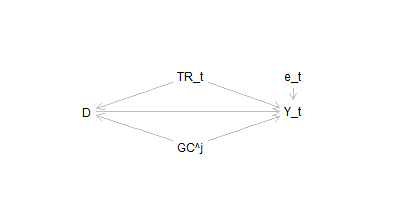

In [5]:
%%R -h 200 -w 400
g = dagitty('
    dag {
    " " [pos="-1.3, -0.4"]
    "" [pos="0.4, 1"]
    "GC^j" [adjusted,pos="-0.5, 0.7"]
    "TR_t" [adjusted,pos="-0.5, 0.1"]
    D [exposure,pos="-1, 0.40"]
    Y_t [outcome,pos="0, 0.40"]
    e_t [pos="0, 0.1"]
    D <- "GC^j" -> Y_t
    D <- "TR_t" -> Y_t
    D -> Y_t
    e_t -> Y_t
    }
')
plot(g)

In [6]:
data_1 = simulate_data(
    tau=-2,
    b_c=1,
    b_t=1,
    mu_gc_c=-1,
    sigma_gc_c=1,
    mu_gc_t=1.5,
    sigma_gc_t=1,
    mu_tgc_c=0,
    sigma_tgc_c=1,
    mu_tgc_t=0,
    sigma_tgc_t=1,
)

### Plot data

Realized control pre-period mean 0.252
Realized control post-period mean 2.847
Realized treated pre-period mean 2.886
Realized treated post-period mean 3.482
Counterfactual (unobserved) treatment post-period mean 5.482
Realized control t_0 mean -0.479
Realized control t_1 mean 0.149
Realized control t_2 mean 1.086
Realized control t_3 mean 2.203
Realized control t_4 mean 2.750
Realized control t_5 mean 3.587
Realized treated t_0 mean 2.070
Realized treated t_1 mean 2.830
Realized treated t_2 mean 3.758
Realized treated t_3 mean 2.815
Realized treated t_4 mean 3.630
Realized treated t_5 mean 3.999
Counterfactual treated (unobserved) t_0 mean 2.070
Counterfactual treated (unobserved) t_1 mean 2.830
Counterfactual treated (unobserved) t_2 mean 3.758
Counterfactual treated (unobserved) t_3 mean 4.815
Counterfactual treated (unobserved) t_4 mean 5.630
Counterfactual treated (unobserved) t_5 mean 5.999
Counterfactual (naively estimated) treated post-period mean 5.481
Naive DiD-estimate -1.99

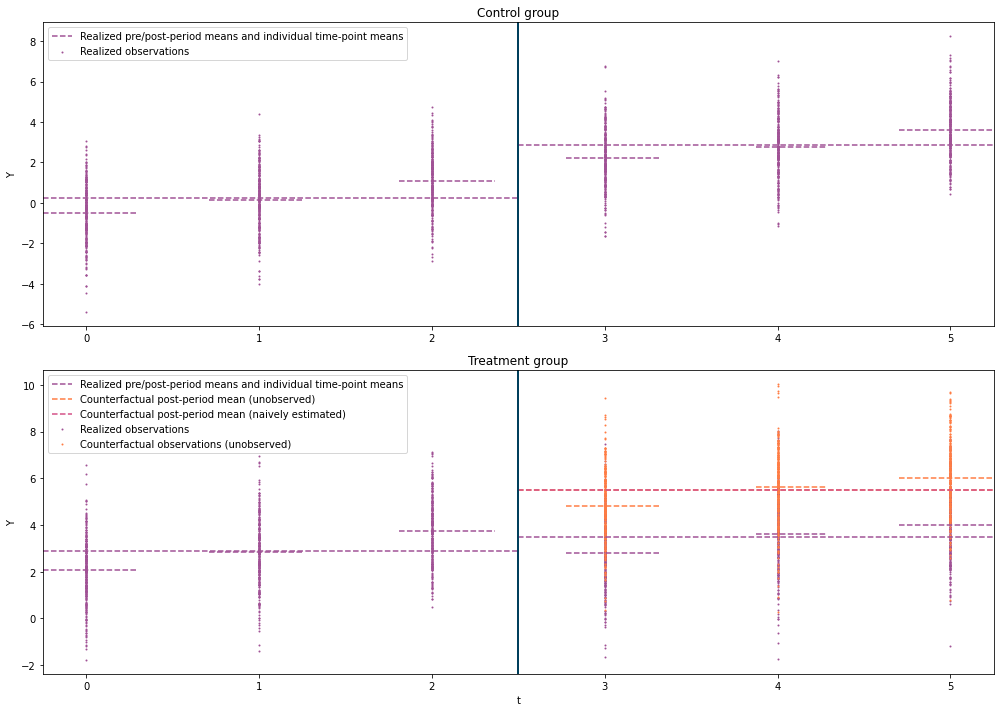

In [7]:
plot_data(data_1)

### Parallel trends assumption

The most important assumption behind the DiD design is the *parallel trend assumption*, which assumes that unmeasured determinants of the outcome are either time or group invariant, but not both. In this particular case, we know that in the DGP there are group invariant ($TR_t^j$) and time invariant ($GC^j$) effects but not both (effect of $TGC_t^j$ is, on average, zero). In reality, the researcher does of course not know the true DGP.

Sometimes the use of parallel trends assumption is validated by looking into the pre-period evolution of the average $E[Y_{i,t}]$ over $t$ between the treatment and control groups. The evolution of these averages can be eye-balled from the plot above (vertcial short dashed lines), but let's drawn the averagaes in a more convinient plot for better comparison. From the plot it becomes obvious that the DGP has the same pre-trend (on average).

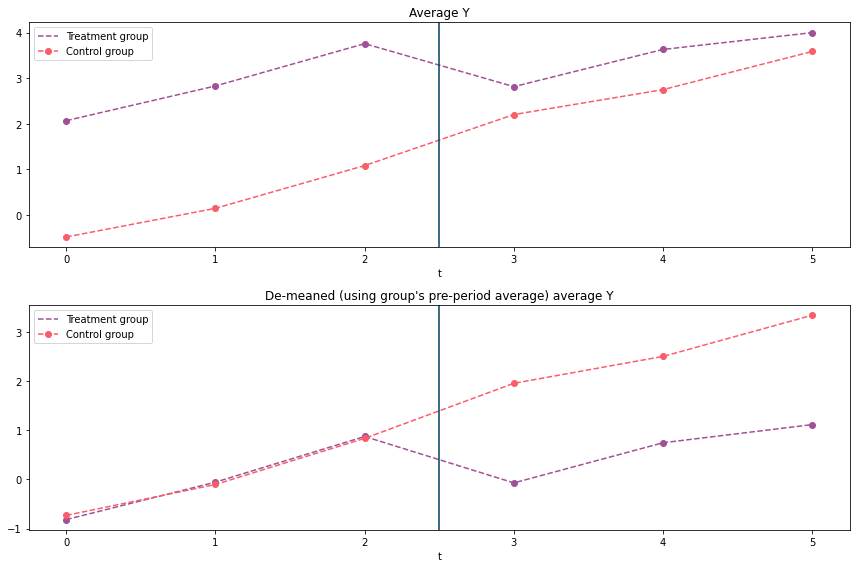

In [8]:
parallel_trends_plot(data_1)

### Regression

In this case the target estimand is

$$
\begin{equation*}
    \theta_{post} = E[Y_{i,post}^T(1)] - E[Y_{i,post}^T(0)]
\end{equation*}
$$

From this estimand it is straighforward to construct an estimator (see the [flashcard](https://raw.githubusercontent.com/NoobQuant/Data_Science_Projects/master/flashcards/diff_in_diff.jpg)) which is effectively a **two-way fixed effects estimator (TWFE)**. It can be employed using the following regression equation:

$$
\begin{equation*}
  Y_{i,t}^j = \alpha + \beta_1 \ \text{dummy\_group}^j + \beta_2 \ \text{dummy\_period}_t + \beta_3 \ \text{dummy\_group\_x\_period}^j_t + \epsilon_{i,t}
\end{equation*}
$$

where

 - $\alpha$ is an intercept;
 - $\epsilon_{i,t}$ denotes the regression residual term;
 - `dummy_group` denotes a dummy variable for treatment group;
 - `dummy_period` denotes a dummy variable for port period;
 - `dummy_group_x_period` denotes the interaction dummy of `dummy_group` and `dummy_period`. 

Findings:

 - Calculating a naive DiD estimate coincides with the true (unobserved) counterfactual. That is, when *TGC* effect is (on average) zero, a naive DiD-estimate of the treatment effect yield a  correct (unbiased) result.

In [9]:
df = prepare_regression_frame(data_1["treatment"], data_1["control"])
reg_str = "Y ~ 1 + dummy_group + dummy_period + dummy_group_x_period"
res = smf.ols(reg_str, data=df).fit()
print("Regression: {}\n".format(reg_str))
print(res.summary())

Regression: Y ~ 1 + dummy_group + dummy_period + dummy_group_x_period

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.392
Model:                            OLS   Adj. R-squared:                  0.391
Method:                 Least Squares   F-statistic:                     771.5
Date:                Mon, 10 Apr 2023   Prob (F-statistic):               0.00
Time:                        11:37:09   Log-Likelihood:                -6695.1
No. Observations:                3600   AIC:                         1.340e+04
Df Residuals:                    3596   BIC:                         1.342e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------

In the above regressions we are controlling for group fixed effects (`tc_group`) and time fixed effects (`time_group`). Notice that typically in the econometric literature regression for a TWFE is written using time/group fixed effects for **all** time points and group:

$$
\begin{equation*}
  Y_{i,t}^j = \eta^j + \nu_t + \beta_3 \ \text{dummy\_group\_x\_period}^j_t + \epsilon_{i,t}
\end{equation*}
$$

where

 - $\eta^j$ denotes group fixed effects;
 - $\nu_t$ denotes time fixed effects.

As we will see below, this makes no difference for the DiD coefficient estimate*. However, standard errors and thus significance bounds do differ a bit due to differing degrees of freedom.

*\*Time fixed effects will become essential for the coeffient estimate when the intervention is staggered, see for example [this](https://stats.stackexchange.com/questions/455986/panel-data-diff-in-diff-and-the-pattern-of-the-binary-treatment-indicator)*.

In [10]:
reg_str = "Y ~ -1 + tc_group + t + dummy_group_x_period"
res = smf.ols(reg_str, data=df).fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.482
Model:                            OLS   Adj. R-squared:                  0.481
Method:                 Least Squares   F-statistic:                     477.8
Date:                Mon, 10 Apr 2023   Prob (F-statistic):               0.00
Time:                        11:37:09   Log-Likelihood:                -6404.9
No. Observations:                3600   AIC:                         1.283e+04
Df Residuals:                    3592   BIC:                         1.288e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
tc_group[control]       -0.5220 

## Classical two-period DiD with TGC effect

Now we simulate data where there is, on average, a $TGC$ effect. The specification is the same otherwise as in the example above, but now  $\mu_{TGC}^C = 1$ and $ \mu_{TGC}^T = 0$. That is, after the intervention $TGC$ will cause confounding by affecting the control group differently.

### Generate data

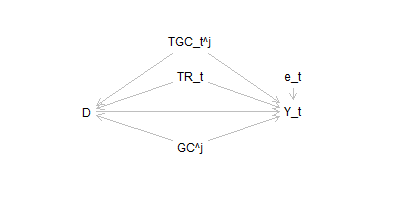

In [11]:
%%R -h 200 -w 400
g = dagitty('
    dag {
    " " [pos="-1.3, -0.4"]
    "" [pos="0.4, 1"]
    "GC^j" [adjusted,pos="-0.5, 0.7"]
    "TGC_t^j" [adjusted,pos="-0.5, -0.2"]
    "TR_t" [adjusted,pos="-0.5, 0.1"]
    D [exposure,pos="-1, 0.40"]
    Y_t [outcome,pos="0, 0.40"]
    e_t [pos="0, 0.1"]
    D <- "GC^j" -> Y_t
    D <- "TGC_t^j" -> Y_t
    D <- "TR_t" -> Y_t
    D -> Y_t
    e_t -> Y_t
    }
')
plot(g)

In [12]:
data_2 = simulate_data(
    tau=-2,
    b_c=1,
    b_t=1,
    mu_gc_c=-1,
    sigma_gc_c=1,
    mu_gc_t=1.5,
    sigma_gc_t=1,
    mu_tgc_c=1,
    sigma_tgc_c=1,
    mu_tgc_t=0,
    sigma_tgc_t=1,
)

## Plot data

Realized control pre-period mean 0.506
Realized control post-period mean 2.519
Realized treated pre-period mean 2.588
Realized treated post-period mean 2.009
Counterfactual (unobserved) treatment post-period mean 4.009
Realized control t_0 mean -0.442
Realized control t_1 mean 0.087
Realized control t_2 mean 1.872
Realized control t_3 mean 0.769
Realized control t_4 mean 1.415
Realized control t_5 mean 5.374
Realized treated t_0 mean 2.117
Realized treated t_1 mean 2.180
Realized treated t_2 mean 3.466
Realized treated t_3 mean 0.372
Realized treated t_4 mean 0.865
Realized treated t_5 mean 4.791
Counterfactual treated (unobserved) t_0 mean 2.117
Counterfactual treated (unobserved) t_1 mean 2.180
Counterfactual treated (unobserved) t_2 mean 3.466
Counterfactual treated (unobserved) t_3 mean 2.372
Counterfactual treated (unobserved) t_4 mean 2.865
Counterfactual treated (unobserved) t_5 mean 6.791
Counterfactual (naively estimated) treated post-period mean 4.601
Naive DiD-estimate -2.59

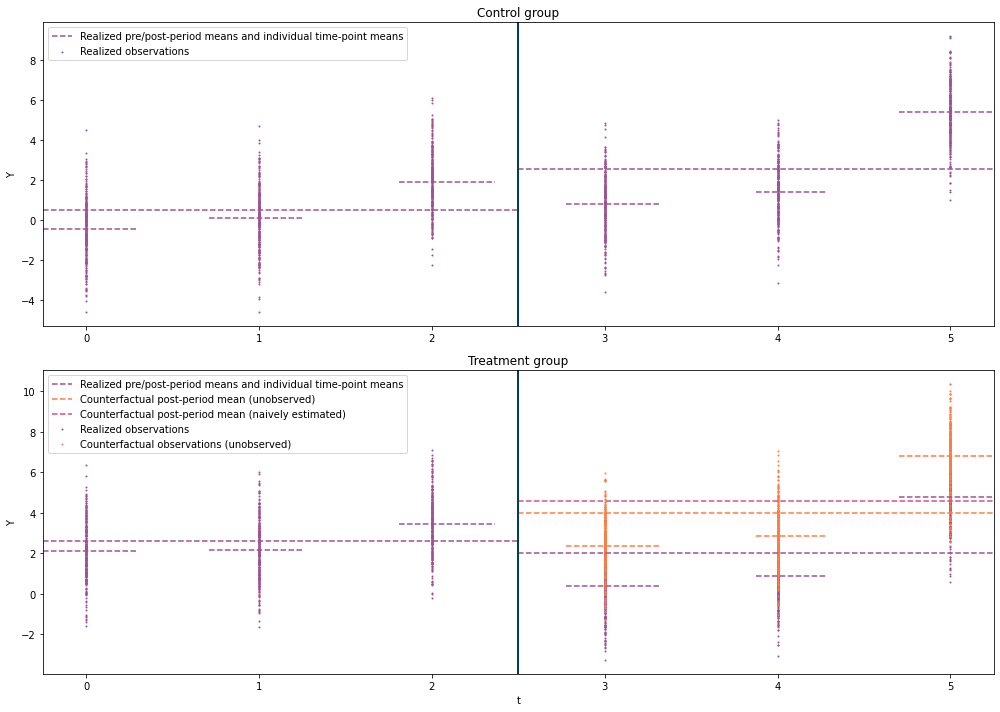

In [13]:
plot_data(data_2)

### Parallel trends assumption

No perfect pre-trend, but pretty good!

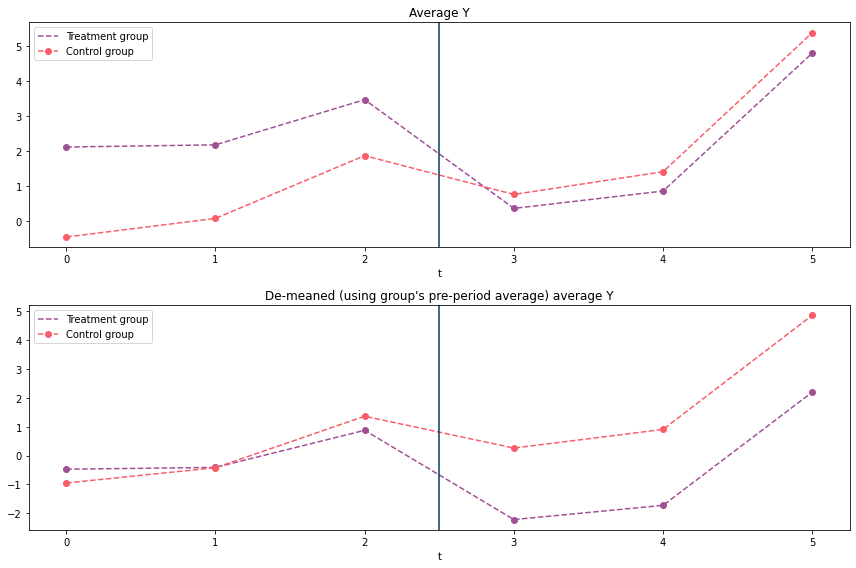

In [14]:
parallel_trends_plot(data_2)

### Regressions

#### Naive DiD

The first regression we try is the same as in the first example.

Findings:

 - When TGC is not zero, naive DiD-estimate of the treatment effect is biased.

In [15]:
df = prepare_regression_frame(data_2["treatment"], data_2["control"])
reg_str = "Y ~ 1 + dummy_group + dummy_period + dummy_group_x_period"
res = smf.ols(reg_str, data=df).fit()
print("Regression: {}\n".format(reg_str))
print(res.summary())

Regression: Y ~ 1 + dummy_group + dummy_period + dummy_group_x_period

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.136
Model:                            OLS   Adj. R-squared:                  0.136
Method:                 Least Squares   F-statistic:                     189.3
Date:                Mon, 10 Apr 2023   Prob (F-statistic):          5.61e-114
Time:                        11:37:11   Log-Likelihood:                -7796.3
No. Observations:                3600   AIC:                         1.560e+04
Df Residuals:                    3596   BIC:                         1.563e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------

#### Adjust for TGC

Next we can try to adjust for *TGC*.

Findings:

 - The DiD-estimate is estimated with less bias (seems there is some bias left?).

In [16]:
df = prepare_regression_frame(data_2["treatment"], data_2["control"])
reg_str = "Y ~ 1 + TGC + dummy_group + dummy_period + dummy_group_x_period"
res = smf.ols(reg_str, data=df).fit()
print("Regression: {}\n".format(reg_str))
print(res.summary())

Regression: Y ~ 1 + TGC + dummy_group + dummy_period + dummy_group_x_period

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.370
Model:                            OLS   Adj. R-squared:                  0.369
Method:                 Least Squares   F-statistic:                     527.5
Date:                Mon, 10 Apr 2023   Prob (F-statistic):               0.00
Time:                        11:37:11   Log-Likelihood:                -7229.1
No. Observations:                3600   AIC:                         1.447e+04
Df Residuals:                    3595   BIC:                         1.450e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------